###### Описание задачи

Входные данные - [биржевой стакан](https://en.wikipedia.org/wiki/Order_book_(trading)) некоторого актива. Он содержит в себе ценовые уровни и объемы заявок на уровне. Глубина стакана - 5.  
В данных приведён стакан на каждый тик биржи.  
ask_rate - цены заявок на продажу  
ask_amount - объёмы заявок на продажу  
bid_rate - цены заявок на покупку  
bid_amount - объёмы заявок на покупку

На каждый тик определим цену актива. Возьмём среднее между наименьшим ask_rate (askbest) и наибольшим bid_rate (bidbest) в момент времени t:  
$$ midprice(t) = (askbest(t) + bidbest(t)) / 2 $$  

Определим целевую переменную. Будем прогнозировать изменение midprice через четыре тика (в момент времени t + 4):
$$ target(t) = midprice(t + 4) - midprice(t) $$ 

**Цель тестового задания - решить задачу регрессии.**  

Данные находятся в двух файлах.  
train.csv - данные для обучения и валидации модели  
test.csv - данные для финальной оценки качества модели  

#### Идеи для признаков:
- суммарный объем заявок в стакане
- дисбаланс объемов всех заявок на продажу и всех заявок на покупку
- разница между лучшей ценой на продажу и лучшей ценой на покупку  
- волатильность цены за период  
- цена n тиков назад

#### Критерии оценки: 
- структура построения пайплайна обучения модели    
- качество кода  
- точность прогноза по метрике RMSE на данных из test.csv 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [2]:
df = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

In [3]:
df.iloc[-7000:].bid_rate.apply(lambda x: max(x)).plot()
df.iloc[-7000:].ask_rate.apply(lambda x: min(x)).plot()

In [4]:
def feature_engine(dframe):
    dframe['best_bid_rate'] = dframe.bid_rate.apply(lambda x: max(x))
    dframe['best_ask_rate'] = dframe.ask_rate.apply(lambda x: min(x))
    dframe['sum_amount'] = dframe.bid_amount.apply(lambda x: np.array(x).sum()) + dframe.ask_amount.apply(lambda x: np.array(x).sum())
    dframe['razn_amount'] = -dframe.bid_amount.apply(lambda x: np.array(x).sum()) + dframe.ask_amount.apply(lambda x: np.array(x).sum())
    dframe['razn_best_amounts'] = dframe.bid_amount.apply(lambda x: max(x)) - dframe.ask_amount.apply(lambda x: min(x))
    dframe['mean_bid_rate'] = dframe.bid_rate.apply(lambda x: np.mean(np.array(x)))
    dframe['mean_ask_rate'] = dframe.ask_rate.apply(lambda x: np.mean(np.array(x)))
    dframe['mean_bid_amount'] = dframe.bid_amount.apply(lambda x: np.mean(np.array(x)))
    dframe['mean_ask_amount'] = dframe.ask_amount.apply(lambda x: np.mean(np.array(x)))

    dframe['max_bid_rate'] = dframe.bid_rate.apply(lambda x: np.max(np.array(x)))
    dframe['max_ask_rate'] = dframe.ask_rate.apply(lambda x: np.max(np.array(x)))
    dframe['max_bid_amount'] = dframe.bid_amount.apply(lambda x: np.max(np.array(x)))
    dframe['max_ask_amount'] = dframe.ask_amount.apply(lambda x: np.max(np.array(x)))
    dframe['min_bid_rate'] = dframe.bid_rate.apply(lambda x: np.min(np.array(x)))
    dframe['min_ask_rate'] = dframe.ask_rate.apply(lambda x: np.min(np.array(x)))
    dframe['min_bid_amount'] = dframe.bid_amount.apply(lambda x: np.min(np.array(x)))
    dframe['min_ask_amount'] = dframe.ask_amount.apply(lambda x: np.min(np.array(x)))


    arr1 = []
    arr2 = []
    price_n = []
    for i in tqdm(range (0, len(dframe))):
        price_n.append(dframe.iloc[i-50].midprice)
        cur1 = dframe.iloc[i-50:i].bid_rate.values
        cur2 = dframe.iloc[i-50:i].ask_rate.values
        x1 = []
        x2 = []
        for c in cur1:
            x1 = np.concatenate((x1, c))
        arr1.append(np.std(x1))
        for c in cur2:
            x2 = np.concatenate((x2, c))
        arr2.append(np.std(x2))
    # df = df[50:]
    dframe['std_bid'] = arr1
    dframe['std_ask'] = arr2
    dframe['price_n'] = price_n
    return dframe
# sm.graphics.tsa.plot_acf(df.iloc[-3000:].ask_rate.apply(lambda x: min(x)).values)

In [5]:
df = feature_engine(df)
test = feature_engine(test)

  0%|          | 0/120000 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 30000/30000 [00:40<00:00, 738.92it/s] 


In [6]:
def feature_select(dframe):
    dff = dframe.copy()[50:]

    target = dff.target.values
    midprice = dff.midprice.values

    dff = dff.drop(["ask_rate", "bid_rate", "ask_amount", "bid_amount", "target"], axis=1)
    return dff, midprice, target

In [7]:
dff, midprice, target = feature_select(df)
test1, midprice1, target1 = feature_select(test)

In [8]:
def train_test_process(n, dframe, dframe1, type_):
    shift_size = n

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in tqdm(range(shift_size, len(dframe)-3)):
        X_train.append(dframe.iloc[i-shift_size:i].values.ravel())
        if(type_ == 'bid'):
            y_train.append(dframe.best_bid_rate[i + 3])
        elif(type_ == 'ask'):
            y_train.append(dframe.best_ask_rate[i + 3])
    for i in tqdm(range(shift_size, len(dframe1)-3)):
        X_test.append(dframe1.iloc[i-shift_size:i].values.ravel())
        if(type_ == 'bid'):
            y_test.append(dframe1.best_bid_rate[i + 3])
        elif(type_ == 'ask'):
            y_test.append(dframe1.best_ask_rate[i + 3])
        
    return X_train, y_train, X_test, y_test

In [9]:
X_train_bid, y_train_bid, X_test_bid, y_test_bid = train_test_process(50, dff, test1, 'bid')
X_train_ask, y_train_ask, X_test_ask, y_test_ask = train_test_process(50, dff, test1, 'ask')

100%|██████████| 29897/29897 [00:02<00:00, 10471.55it/s]


In [10]:
dff.shape, test1.shape

((119950, 21), (29950, 21))

In [11]:
X_train_bid, y_train_bid = np.array(X_train_bid), np.array(y_train_bid)
X_train_ask, y_train_ask = np.array(X_train_ask), np.array(y_train_ask)

In [12]:
X_test_bid, y_test_bid = np.array(X_test_bid), np.array(y_test_bid)
X_test_ask, y_test_ask = np.array(X_test_ask), np.array(y_test_ask)

In [13]:
print(X_train_bid.shape)
print(X_test_bid.shape)

print(X_train_ask.shape)
print(X_test_ask.shape)

print(y_train_bid.shape)
print(y_test_bid.shape)

print(y_train_ask.shape)
print(y_test_ask.shape)

(119897, 1050)
(29897, 1050)
(119897, 1050)
(29897, 1050)
(119897,)
(29897,)
(119897,)
(29897,)


In [55]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import lightgbm as lgb

def process_regression(X_train, y_train, X_test, y_test):
    params = {'num_leaves': 1000,
          'objective': 'regression',
          'max_depth': 20,
          'learning_rate': 0.001,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'rmse',
          "verbosity": -1,
          'random_state': 222,
          'n_estimators': 25
         }
    gbm = lgb.LGBMRegressor(**params)

    gbm.fit(X_train[:119000], y_train[:119000],eval_set=[(X_train[119000:], y_train[119000:])],
            eval_metric='l1',
            early_stopping_rounds=1000)

    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

    rmse = round(mean_squared_error(y_pred, y_test) ** 0.5, 5)
    return y_pred, rmse

In [56]:
y_pred1, rmse1 = process_regression(X_train_ask, y_train_ask, X_test_ask, y_test_ask)
y_pred, rmse = process_regression(X_train_bid, y_train_bid, X_test_bid, y_test_bid)


[1]	valid_0's l1: 37.422	valid_0's rmse: 42.9289
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l1: 37.4033	valid_0's rmse: 42.9074
[3]	valid_0's l1: 37.3846	valid_0's rmse: 42.886
[4]	valid_0's l1: 37.3659	valid_0's rmse: 42.8645
[5]	valid_0's l1: 37.3473	valid_0's rmse: 42.8431
[6]	valid_0's l1: 37.3286	valid_0's rmse: 42.8217
[7]	valid_0's l1: 37.3099	valid_0's rmse: 42.8003
[8]	valid_0's l1: 37.2913	valid_0's rmse: 42.7789
[9]	valid_0's l1: 37.2726	valid_0's rmse: 42.7575
[10]	valid_0's l1: 37.254	valid_0's rmse: 42.7361
[11]	valid_0's l1: 37.2354	valid_0's rmse: 42.7148
[12]	valid_0's l1: 37.2167	valid_0's rmse: 42.6934
[13]	valid_0's l1: 37.1981	valid_0's rmse: 42.672
[14]	valid_0's l1: 37.1795	valid_0's rmse: 42.6507
[15]	valid_0's l1: 37.161	valid_0's rmse: 42.6294
[16]	valid_0's l1: 37.1424	valid_0's rmse: 42.6081
[17]	valid_0's l1: 37.1238	valid_0's rmse: 42.5868
[18]	valid_0's l1: 37.1052	valid_0's rmse: 42.5655
[19]	valid_0's l1: 37.0867	valid_

In [57]:
from math import sqrt
def process_answer(y_pred, y_pred1, target):
    pred_mid = []
    for a, b in zip(y_pred, y_pred1):
        pred_mid.append((a + b) / 2)
    pred_target = []
    for i in range(len(pred_mid)):
        pred_target.append(pred_mid[i + 4] - pred_mid[i]) if(i + 4 < len(pred_mid)) else pred_target.append(0)
    return sqrt(mean_squared_error(pred_target, target[50:-3]))

In [58]:
process_answer(y_pred, y_pred1, target1)

10.515634629910139

In [95]:
import xgboost as xgb

def boosting(X_train_bid, y_train_bid, X_test_bid, y_test_bid):
    dtrain = xgb.DMatrix(X_train_bid, label=y_train_bid)
    dtest = xgb.DMatrix(X_test_bid)

    params = {
            'objective': 'reg:linear',
            'booster':'gblinear'
        }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    prediction_train = bst.predict(dtrain)

    prediction_test = bst.predict(dtest)

    print(sqrt(mean_squared_error(prediction_test, y_test_bid)))

In [ ]:
boosting(X_train_ask[60000:], y_train_ask[60000:], X_test_ask, y_test_ask)

[02:16:38] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:45] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:16:54] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:17:01] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:17:07] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:17:14] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:17:20] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is no

In [39]:

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 100
}


[1]	valid_0's l1: 128.341	valid_0's l2: 30255.8
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l1: 115.58	valid_0's l2: 24525.1
[3]	valid_0's l1: 104.063	valid_0's l2: 19871.8
[4]	valid_0's l1: 93.5881	valid_0's l2: 16042.2
[5]	valid_0's l1: 84.2725	valid_0's l2: 13001
[6]	valid_0's l1: 75.7673	valid_0's l2: 10500.2
[7]	valid_0's l1: 68.1241	valid_0's l2: 8487.09
[8]	valid_0's l1: 61.2634	valid_0's l2: 6859.82
[9]	valid_0's l1: 55.1025	valid_0's l2: 5548.7
[10]	valid_0's l1: 49.4921	valid_0's l2: 4466.44
[11]	valid_0's l1: 44.4674	valid_0's l2: 3603.47
[12]	valid_0's l1: 39.9383	valid_0's l2: 2898.72
[13]	valid_0's l1: 35.8885	valid_0's l2: 2341.29
[14]	valid_0's l1: 32.2449	valid_0's l2: 1887.27
[15]	valid_0's l1: 28.9624	valid_0's l2: 1523.12
[16]	valid_0's l1: 26.0617	valid_0's l2: 1233.03
[17]	valid_0's l1: 23.4637	valid_0's l2: 999.163
[18]	valid_0's l1: 21.1054	valid_0's l2: 809.027
[19]	valid_0's l1: 18.9702	valid_0's l2: 655.683
[20]	valid_0's l1: 

In [41]:
pred_mid = []
for a, b in zip(y_pred, y_pred1):
    pred_mid.append((a + b) / 2)
pred_target = []
# len(pred_mid)
for i in range(len(pred_mid)):
    pred_target.append(pred_mid[i + 4] - pred_mid[i]) if(i + 4 < len(pred_mid)) else pred_target.append(0)
len(pred_target)

29897

In [42]:
sqrt(mean_squared_error(pred_target, target1[50:-3]))

16.877538597245895

In [54]:
from math import sqrt

def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = sqrt(metrics(model.predict(X_testFold), y_testFold))

    # the function returns the mean of the errors on the n-1 folds    
    return (errors.mean())

In [55]:
lr = LinearRegression()

print(performTimeSeriesCV(X_train_bid, y_train_bid, 5, lr, mean_squared_error))

lr.fit(X_train_bid, y_train_bid)
# print(X_train_bid.shape)
prediction = lr.predict(X_test_bid)

lr1 = LinearRegression()

print(performTimeSeriesCV(X_train_ask, y_train_ask, 5, lr1, mean_squared_error))

lr1.fit(X_train_ask, y_train_ask)
prediction1 = lr1.predict(X_test_ask)

print(sqrt(mean_squared_error(prediction, y_test_bid)))
print(sqrt(mean_squared_error(prediction1, y_test_ask)))

Size train set: (119897, 1050)
Size of each fold: 23979

Splitting the first 2 chunks at 1/2
Size of train + test: (47958, 1050)

Splitting the first 3 chunks at 2/3
Size of train + test: (71937, 1050)

Splitting the first 4 chunks at 3/4
Size of train + test: (95916, 1050)

Splitting the first 5 chunks at 4/5
Size of train + test: (119895, 1050)
4.495766110199344e-11
Size train set: (119897, 1050)
Size of each fold: 23979

Splitting the first 2 chunks at 1/2
Size of train + test: (47958, 1050)

Splitting the first 3 chunks at 2/3
Size of train + test: (71937, 1050)

Splitting the first 4 chunks at 3/4
Size of train + test: (95916, 1050)

Splitting the first 5 chunks at 4/5
Size of train + test: (119895, 1050)
3.889152631296485e-11
5.2469161446959924e-11
6.021837490482152e-11


In [56]:
pred_mid = []
for a, b in zip(prediction, prediction1):
    pred_mid.append((a + b) / 2)
pred_target = []
# len(pred_mid)
for i in range(len(pred_mid)):
    pred_target.append(pred_mid[i + 4] - pred_mid[i]) if(i + 4 < len(pred_mid)) else pred_target.append(0)
len(pred_target)

29897

In [57]:
midprice1.shape
mp = np.array(midprice1)
len(mp[50:-3])

29897

In [58]:
sqrt(mean_squared_error(pred_target, target1[50:-3]))

14.835114091056047

In [30]:
target1.shape

(29950,)

In [44]:
sqrt(mean_squared_error(np.array(target1), np.zeros(29950)))

10.514359368099223

120000it [00:28, 4225.41it/s]


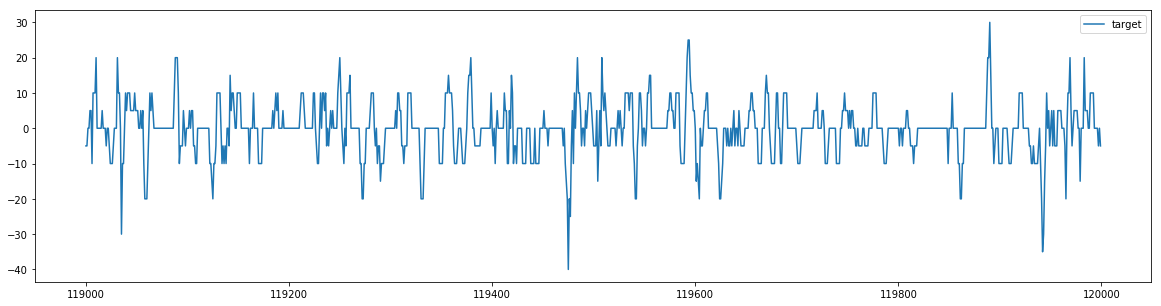

In [50]:
# df.iloc[0]['ask_rate']
from tqdm import tqdm
df1 = pd.DataFrame()

sum_amounts = []
dis_balance = []
best_price_razn = []
target = []

for index, row in tqdm(df.iterrows()):
    sum_amounts.append(np.sum(row['ask_amount']) + np.sum(row['bid_amount']))
    dis_balance.append(np.sum(row['ask_amount']) - np.sum(row['bid_amount']))
    best_price_razn.append(np.max(row['ask_rate']) - np.max(row['bid_rate']))
    target.append(row['target'])
# df1['sum_amount'] = sum_amounts
# df1['dis_balance'] = dis_balance
# df1['best_price_razn'] = best_price_razn
df1['target'] = target
df1[-1000:].plot()

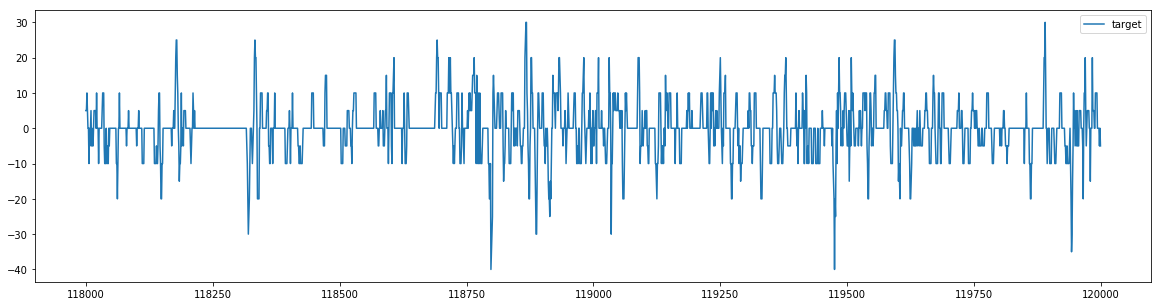

In [53]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
df1[-2000:].plot()

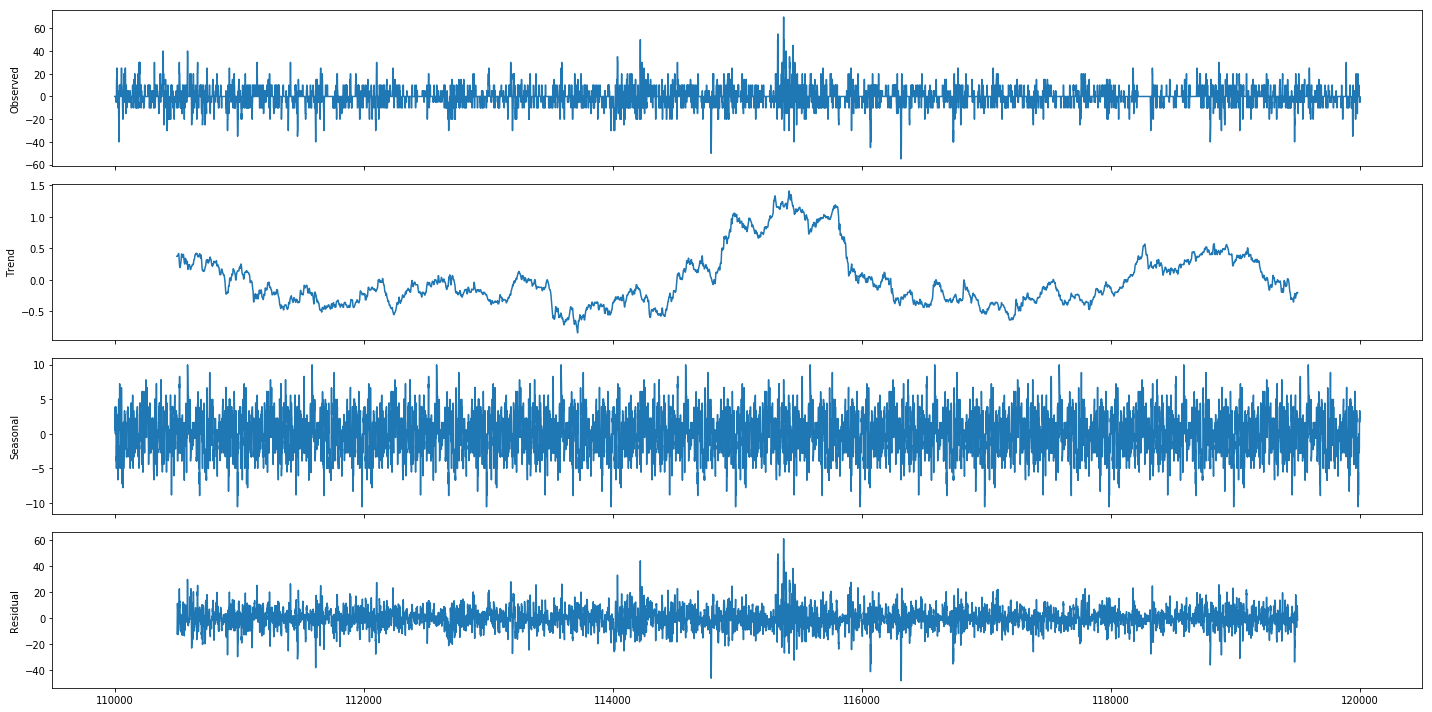

In [65]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
rcParams['figure.figsize'] = 20, 10
result = sm.tsa.seasonal_decompose(df1[-10000:], model='additive', freq=1000)
result.plot()
plt.show()